# Introduction to Graph Convolutional Network 

Many important real-world datasets come in the form of graphs or networks: social networks, citation networks, protein-interaction networks, the World Wide Web, etc. The high interpretability of graph and the rise of deep learning has motivated to create a new intersection between deep learning and graph theory. When both these fields basically meet they create what we call geometric deep learning or graph neural network. It has demonstrated ground-breaking performance on many tasks that require a model to learn from graph inputs. This blog post will cover the basics of Graph Convolutional Network (GCN) and provide an intuitive explaination how it works together with some coding examples. 

## What is a Graph Convolutional Network? 

Basically, GCN is a neural network which operates on graphs and can be understood as a simple message passing algorithm. More formally, GCNs are "connectionist models that capture the dependence of graphs via message passing between the nodes of graphs" [1]. Note that the idea of message passing in a graph is a really powerful concept as it provides the explanation for a lot of graph algorithms. In a nutshell the idea is that a node in a graph can send and receive messages along its connections with its neighbors. This can be seen as a process with two steps: first, nodes will send out a message about itself to its neighbor, and second, nodes integrate the neighbor messages and use them in some way to update itself and understand its environment. Eventually, a new representation of the node is generated and not only provide the node's own information but also reflect the information of its neighboring nodes. It is pretty easy, right?

Let's make this concrete through a simple GCN. Suppose we have an input graph where there is a set of nodes, and a set of edges, and our target node $A$. Our task here is how to learn a new representation of node A via GCN. 

![img](image/GNN.png)


Figure 1. Illustration of a graph and a GCN. Adapted from [2]. 

The process can be defined as multiple layers of non-linear transformation of graph structure. First, for any node in the graph, we look at it immediate neighboring nodes. For example, here A is chosen as our node of interest, it is very straightforward to define its connected nodes which are B, C, and D. Next, we need to aggregate information (message) from all those neighbors. Note that each node has a feature vector defining it (e.g. for social networks the features can be age, gender, political leaning). 

To aggregate information, first get all of the feature vectors of its connected nodes, B,C,D node in our case, and apply some aggregation function. You can think about a simple aggregation function like an average. This makes some intuitive sense that a node might be represented by the average of its neighbors. Next, we pass this average vector through a dense neural network layer that is a fancy way of saying that we multiply it by some weight matrix and then apply a nonlinear activation function. The final output of this dense layer is the new vector representation of this node. Now, a node is not just an average of its connected nodes but the average of its neighboring nodes passed through some nonlinear function. This is the intuition behind the inner working of a single layer GCN. 

To make network become deeper, we can do similarly with neighboring nodes of node A (neighbor of neighbor). The subplot on the right-hand side of Figure 1 shows architecture of a two layer GCN. $X_A, X_B, X_C, X_D, X_E$, and $X_F$ denote the feature vector of each node respectively. In this GCN, we do not only look at immediate neighbors of node A, for each neighbor of node A we also find its neighbors. In particular, we find that B, C, and D are neighbors of node A, and we look for neighbors of node B, C, D as well. Neighbors of node B, C, D are {A and C}, {A, B, E and F}, and {A} respectively (we use curly brackets to clearly show a set of neighbors for each node). After that for each node B, C, and D, we also perform the process of integrating information, similar as what we have done with node A. 

Overall, the process of generating a new representation of node A in a two-layer GCN can be summarized as follows. After we find neighbors of neighbors of node A and we have the original input features of these nodes in the input graph, we take aggregation of these nodes and then apply a nonlinear transformation which is shown inside the box in the first layer in Figure 1. The output of the first layer (Layer-1) is the new representation of node B, C, and D which have already integrated information from their neighbors. Finally, this new representation of node B, C, and D is fed as input to generate the new representaion of node A in the second layer (Layer-2). 

Note that we can change our target node to other nodes and generate the new embeddings for nodes as needed. Through the timesteps of message passing, the nodes know more about their own information (features) and that of neighbouring nodes. The deeper the network, the larger the local neighbourhood. You can think of it as the generalisation of the receptive field of a neuron in a normal Convolutional Neural Network [3]. This network is applied convolutionally across the entire graph, always receiving features from the relevant neighbours around each node. Eventually, this helps create an even more accurate representation of the entire graph. 

Now let's look at a coding example of GCN with Python. 


## Coding example

* Given a graph $G = (V, E)$ takes as input:
    * A $N \times F^0$ input feature matrix, $X$, where $N$ is the number of nodes and $F^0$ is the number of input features for each node, and
    * A $N \times N$ matrix representation of the graph structure such as the adjacency matrix $A$ of $G$.
* A hidden layer in GCN can be written as $H^i = f(H^{i-1}, A))$ where $H^0 = X$ and $f$ is a propagation rule. Each layer $H^i$ corresponds to an $N \times F^i$ feature matrix where each row is a feature representation of a node.
* The specific models then differ only in the choice of $f$. One of the simplest possible propagation rule is:

    $f(H^i, A) = \sigma(AH^iW^i)$

    where $W^i$ is the weight matrix for layer $i$ and $\sigma$ is a non-linear activation function [4]. 

Let's create a simple directed graph

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.linalg import fractional_matrix_power
np.set_printoptions(precision=3)

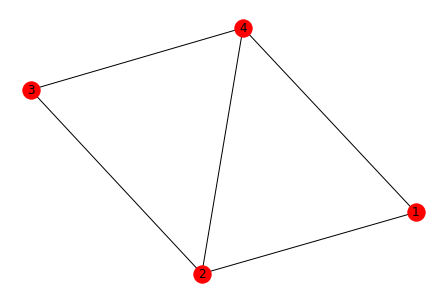

In [3]:
G = nx.Graph(directed=True)
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2), (2,3), (2,4), (4,1),(4,3)])
nx.draw(G, with_labels=True)

And we find its adjacency matrix representation.

In [4]:
A = nx.adjacency_matrix(G).todense()
A

matrix([[0, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 0, 1],
        [1, 1, 1, 0]], dtype=int64)

Since the graph has four nodes so its adjacency matrix has four rows and four column. The first row will encode all the connections of node 1. Since node 1 is only connected with node 2 and 4, we have the value of one in second and fourth column, and zero in all the others. Then, we do the same for node 2, 3, and 4 in the next rows.

Next, we need to create some features. We generate two integer features for every node based on its index. This help to makes it easy to confirm the matrix calculations manually later.

In [5]:
X = np.matrix([[i, -i]
            for i in range(A.shape[0])], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

Let’s examine the propagation rule at its most simple level. Let
* $i = 1$
* $\sigma$ be the identity function
* choose the weight s.t $AH^0W^0 = AXW^0 = AX$

Thus, $f(X,A) = AX$.

In [6]:
A*X

matrix([[ 4., -4.],
        [ 5., -5.],
        [ 4., -4.],
        [ 3., -3.]])

The representation of each node (each row) is now a sum of its neighbors features. In other words, the graph convolutional layer represents each node as an aggregate of its neighborhood. However, there are two limitations in this new representation as follows:

* The aggregated representation of a node does not include its own features. We can solve this problem by adding self-loops.
* Nodes with large degrees will have large values in their feature representation while nodes with small degrees will have small values. This can be solved by transforming the adjacency matrix $A$ by multiplying it with the inverse degree matrix $D$.
    Thus, our propagation rule will look like this:
    $f(X,A) = D^{-1} AX$ 
    
Let's look at how we solve it using code.

In [8]:
# Trick 1: adding self-loops
I = np.matrix(np.eye(A.shape[0]))
A_hat = A + I
A_hat

matrix([[1., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [11]:
# trick 2: normalizing the feature representations
# compute the degree matrix of the new adjacency matrix
D_hat = np.array(np.sum(np.array(A_hat), axis=1))
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[3., 0., 0., 0.],
        [0., 4., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 4.]])

We now combine the two tricks and then reintroduce the weights and activation function.

In [14]:
# Adding back the weights
W = np.matrix([[1, -1],
             [-1, 1]])
# Combining these two tricks we have
D_hat**-1 * A_hat * X * W

matrix([[ 2.667, -2.667],
        [ 3.   , -3.   ],
        [ 4.   , -4.   ],
        [ 3.   , -3.   ]])

Finally, we add a nonlinear activation function, for example, ReLu as follows. 

In [15]:
def relu(X):
   return np.maximum(0,X)

relu(D_hat**-1 * A_hat * X * W)

matrix([[2.667, 0.   ],
        [3.   , 0.   ],
        [4.   , 0.   ],
        [3.   , 0.   ]])

Congratulations! We have just created a single layer GCN with adjacency matrix, input features, weights, and activation function. 

## Key ideas

GCNs are becoming increasingly popular given their expressive power and explicit representation of graphical data. So far, we have learned the basics of Graph Convolutional Network and the intuition behind its inner working. Most importantly, we have seen how the feature representation of a node at each layer in GCN is integrated from that of its neighbors. In addition, we also performed building these networks using numpy in Python. This blog post have shed some light on GCN basics, however, it is just the tip of the iceberg. Do explore beyond this blog and implement GCNs with practical applications. 

## References
[1] Zhou, J., Cui, G., Zhang, Z., Yang, C., Liu, Z., Wang, L., Li, C. and Sun, M., 2018. Graph neural networks: A review of methods and applications. arXiv preprint arXiv:1812.08434.

[2] A tutorial on Representation Learning on Networks. http://snap.stanford.edu/proj/embeddings-www/

[3] A discussion post on Graph Convolutional Neural Networks by Ferenc Huszar. https://www.inference.vc/how-powerful-are-graph-convolutions-review-of-kipf-welling-2016-2/

[4] A blog post on Graph Convolutional Neural Networks by Thomas Kipf. https://tkipf.github.io/graph-convolutional-networks/

[5] A blog post on Introduction about Graph Convolutional Neural Networks by Tobias Skovgaard Jepsen. https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780